## Importing and installing libraries though to be used later on...


In [2]:
import numpy as np
import pandas as pd
import requests
!pip install folium
import folium
from pandas.io.json import json_normalize
import sys

## Loading the previously created dataframe (with  neighbourhood coordinates)

In [41]:
## Loading the prepared csv file into a dataframe
bor_df = pd.read_csv("latlng_scraped_canadian_postal_codes.csv")

In [42]:
### Dropping the index column
bor_df.drop(columns = ["Unnamed: 0"], inplace = True)

In [43]:
bor_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,Lawrence Manor,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


## Declaring helper functions and credentials for FourSquare API
Please note that the credentials have been removed before publishing due to security reasons

In [102]:
### Foursquare credentials
client_id = "REMOVED DUE TO SECURITY REASONS"
client_secret = "REMOVED DUE TO SECURITY REASONS"
access_token = "REMOVED DUE TO SECURITY REASONS"


In [12]:
def explore_area_nearby(lat, lng, radius = 500, limit = 100):
    version = '20180605' # Foursquare API version
    base_url_template = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}'
    lat_lng_suffix = "&ll={},{}"
    base_url = base_url_template.format(client_id, client_secret, access_token, version, radius, limit)
    request_url = base_url + lat_lng_suffix.format(lat, lng)
    #print(request_url)
    resp = requests.get(request_url)
    return resp.json()

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def process_json_response(json_data):
    venues = json_data['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.replace("\n", "").split(".")[-1] for col in nearby_venues.columns]
    return nearby_venues

### Testing whether the functions work/ have not exceeded the hourly quota limit...

In [14]:
json_data = explore_area_nearby(43.753259, -79.329656)
venues = json_data['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

<ipython-input-14-821553b9224d>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


## Performing data retrieval

In [30]:
retrieved_data_df = pd.DataFrame(columns = ["PostalCode", 'name', 'categories', 'lat', 'lng'])
progress_blocks = 20
errors = []

The retrieval of one of the neighbourhoods was not possible. However, it was regarded as of minimal influence on the outcome, therefore, it was ignored.

In [31]:
for i, index in enumerate(bor_df.index):
    lat, lng = bor_df.loc[index, ["Latitude", "Longitude"]]
    pcode = bor_df.loc[index, "PostalCode"]
    try:
        json_data = explore_area_nearby(lat, lng)
        temp_df = process_json_response(json_data)
        temp_df.loc[:, "PostalCode"] = pcode
        retrieved_data_df = retrieved_data_df.append(temp_df)
    except:
        errors.append(index)
    
    done = int(i / bor_df.shape[0] * progress_blocks)
    output = "\r|" + done * "#" + (progress_blocks-done) * "-" + "| done: {}/{}, errors: {}".format(i+1, bor_df.shape[0], len(errors))
    sys.stdout.write(output)

<ipython-input-13-5f5e3b8e1bf6>:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


|###################-| done: 103/103, errors: 1

In [287]:
retrieved_data_df.to_csv("retrieved_neighbour_venues.csv")

In [5]:
retrieved_data_df = pd.read_csv("retrieved_neighbour_venues.csv")

In [6]:
retrieved_data_df.head()

,Unnamed: 0,PostalCode,name,categories,lat,lng
0,0,M3A,Brookbanks Park,Park,43.751976,-79.332140
1,1,M3A,Careful & Reliable Painting,Construction & Landscaping,43.752622,-79.331957
2,2,M3A,649 Variety,Convenience Store,43.754513,-79.331942
3,3,M3A,Towns On The Ravine,Hotel,43.754754,-79.332552
4,4,M3A,Sun Life,Construction & Landscaping,43.754760,-79.332783


## Performing clustering

### Step 1: getting the mean of each category for each postcode

In [7]:
dummies = pd.get_dummies(retrieved_data_df["categories"])

In [8]:
dummies.shape

(3098, 322)

In [9]:
dummies["PostalCode"] = retrieved_data_df["PostalCode"]

In [10]:
groupby_df = dummies.groupby("PostalCode").mean()
groupby_df

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1C,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1E,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1G,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M1H,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M9N,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M9P,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M9R,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 2: performing clustering

In [11]:
from sklearn.cluster import KMeans

In order to find the ideal cluster number, the "elbow-technique" will be used.

In [12]:
ks = range(2, 30)
ssdi = []
for k in ks:
    model = KMeans(init = "k-means++", n_clusters = k, n_init = 50)
    model.fit(groupby_df)
    ssdi.append(model.inertia_)

Plotting the inertia for each k

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
mpl.rcParams["figure.figsize"] = 20,10

Text(0.5, 1.0, 'The change of inertia w.r.t. the change of K')

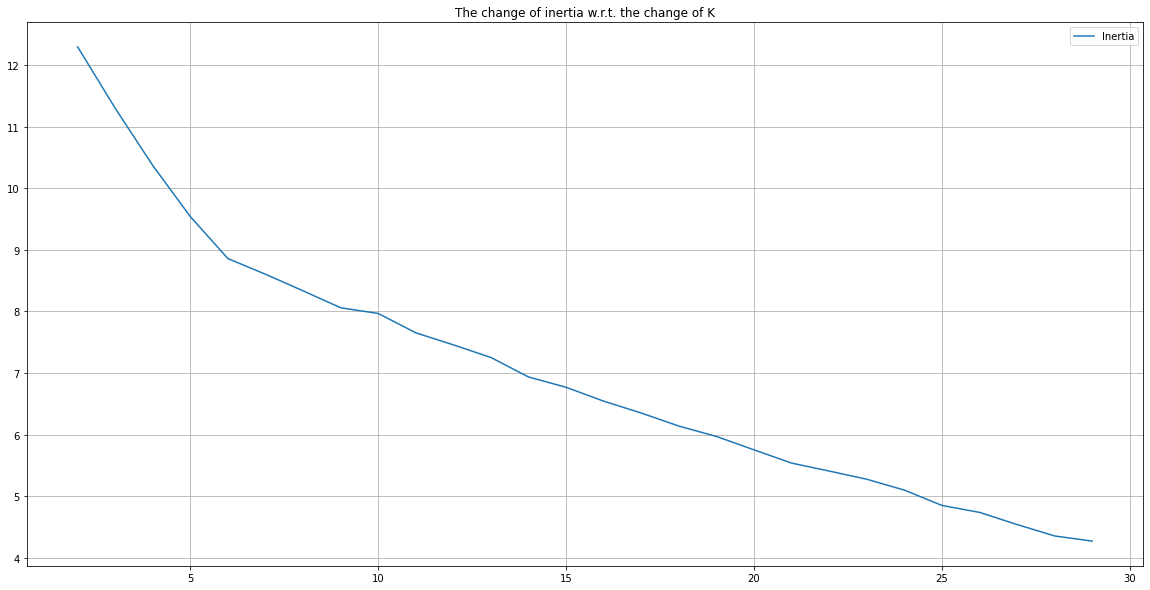

In [15]:
fig, ax = plt.subplots()
ax.plot(list(ks), ssdi, label = "Inertia")
ax.grid()
ax.legend()
ax.set_title("The change of inertia w.r.t. the change of K")

The first relatively big change change in the angle of the slope in the above plot is at k = 6. However, after running the loop above several times, it keeps fluctuating between 4-7, additionally, it sometimes creates clusters where there is only 1 venue type with the mean of 1. This is undesired behaviour. Perhaps a different clustering technique, such as DBSCAN would be a better choice in this case, though, the assignment prescribes K-means, therefore the analysis will be limited to this algorithm's results.

### watch out: the suffix in the following cells does not imply the k number.

In [16]:
# watch out: the suffix in the following cells does not imply the k number.
selected_model_4 = KMeans(init = "k-means++", n_clusters = 6, n_init = 50)
selected_model_4.fit(groupby_df)
labels_4 = selected_model_4.labels_

## What are the characteristics of each cluster?
Great, we have 6 clusters based on every category, but what are the storngest characteristics of these clusters? In order to determine this, the 10 venue types with the highest mean will be selected.

In [17]:
### Adding the labels to each cluster
groupby_df_4 = groupby_df.copy()
groupby_df_4["cluster"] = labels_4


In [19]:
clustergroups_df_4 = groupby_df_4.groupby(by = "cluster").mean()

In [20]:
clustergroups_df_4

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.000000,0.00000,0.00000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
2,0.0034,0.003639,0.00013,0.00013,0.000684,0.000684,0.000684,0.001367,0.002051,0.001367,...,0.000644,0.00126,0.003939,0.000342,0.00022,0.001039,0.000942,0.000943,0.001058,0.003889
3,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.020000,0.025000
4,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
# Creating the columns for the dataframe for cluster characteristics
feature_cols = ["cluster"]
feature_cols += ["ven_type_{}".format(i) for i in range(1,11)]
feature_cols += ["ven_freq_{}".format(i) for i in range(1,11)]

In [23]:
print(feature_cols)

['cluster', 'ven_type_1', 'ven_type_2', 'ven_type_3', 'ven_type_4', 'ven_type_5', 'ven_type_6', 'ven_type_7', 'ven_type_8', 'ven_type_9', 'ven_type_10', 'ven_freq_1', 'ven_freq_2', 'ven_freq_3', 'ven_freq_4', 'ven_freq_5', 'ven_freq_6', 'ven_freq_7', 'ven_freq_8', 'ven_freq_9', 'ven_freq_10']


### Extracting features for k = 6

In [24]:
cluster_features_4 = pd.DataFrame(columns = feature_cols)

for i in clustergroups_df_4.reset_index().index:
    temp_df = pd.DataFrame(columns = feature_cols)

    temp_df.loc[0, "cluster"] =clustergroups_df_4.reset_index().loc[i]["cluster"]
    
    temp_df.iloc[0, 1:11] = clustergroups_df_4.reset_index().iloc[i, 1:].sort_values(ascending = False)[0:10].index.tolist()
    temp_df.iloc[0, 11:] = clustergroups_df_4.reset_index().iloc[i, 1:].sort_values(ascending = False)[0:10].values.tolist()
    cluster_features_4 = cluster_features_4.append(temp_df)

In [25]:
cluster_features_4 = cluster_features_4.reset_index().drop(columns = "index")
cluster_features_4

,cluster,ven_type_1,ven_type_2,ven_type_3,ven_type_4,ven_type_5,ven_type_6,ven_type_7,ven_type_8,ven_type_9,...,ven_freq_1,ven_freq_2,ven_freq_3,ven_freq_4,ven_freq_5,ven_freq_6,ven_freq_7,ven_freq_8,ven_freq_9,ven_freq_10
0,0,Construction & Landscaping,Park,Business Service,Electronics Store,Home Service,Convenience Store,Paper / Office Supplies Store,Fabric Shop,Baseball Field,...,0.26503,0.123065,0.0543155,0.0458333,0.0428571,0.0375,0.03125,0.03125,0.03125,0.03125
1,1,Women's Store,Financial or Legal Service,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,...,1,0,0,0,0,0,0,0,0,0
2,2,Coffee Shop,Pizza Place,Café,Pharmacy,Sandwich Place,Spa,Restaurant,Grocery Store,Park,...,0.057108,0.0355069,0.031418,0.0272279,0.0239778,0.0203725,0.0196179,0.018993,0.0171929,0.0162206
3,3,Park,Trail,Convenience Store,Intersection,Playground,Jewelry Store,Gym,Cafeteria,Home Service,...,0.321667,0.065,0.05,0.05,0.045,0.045,0.0333333,0.0333333,0.0333333,0.0333333
4,4,Home Service,Fast Food Restaurant,Print Shop,Gift Shop,Pool,Baseball Field,Business Service,Ice Cream Shop,Korean Restaurant,...,0.408333,0.125,0.0833333,0.0833333,0.05,0.05,0.05,0.05,0.05,0.05
5,5,Pizza Place,Home Service,Pharmacy,Concert Hall,Escape Room,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,...,0.666667,0.166667,0.166667,0,0,0,0,0,0,0


As it can be seen above, there is 1 cluster with exclusively one venue_frequency greater than 0. This is not really a desired behaviour. Just to double check the assumption of them being anomalies and single member clusters, let's examine them using numpy's unique function.

In [27]:
labels_np = np.array(labels_4)
unique_elements, counts_elements = np.unique(labels_np, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
print("As it can be seen, cluster '1' has only one occurence.")

Frequency of unique values of the said array:
[[ 0  1  2  3  4  5]
 [ 8  1 77 10  4  2]]
As it can be seen, cluster '1' has only one occurence.


In [28]:
columns_for_comparison = np.unique(cluster_features_4.iloc[:, 1:11].values)
one_hot_cluster_venues = pd.DataFrame(columns = ["cluster"] + columns_for_comparison.tolist())
columns_for_comparison.shape

(42,)

In [29]:
one_hot_cluster_venues

,cluster,Baseball Field,Business Service,Cafeteria,Café,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Doner Restaurant,...,Pharmacy,Pizza Place,Playground,Pool,Print Shop,Restaurant,Sandwich Place,Spa,Trail,Women's Store


In [30]:
for i in cluster_features_4.index:
    temp_df = cluster_features_4.loc[i]
    
    one_hot_cluster_venues.loc[i, "cluster"] = i
    
    for col in temp_df.values[1:11]:
        one_hot_cluster_venues.loc[i, col] = 1

one_hot_cluster_venues.fillna(0, inplace = True)    
one_hot_cluster_venues

,cluster,Baseball Field,Business Service,Cafeteria,Café,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Doner Restaurant,...,Pharmacy,Pizza Place,Playground,Pool,Print Shop,Restaurant,Sandwich Place,Spa,Trail,Women's Store
0,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,1,1,0,0,0,0,...,1,1,0,0,0,1,1,1,0,0
3,3,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,4,1,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
5,5,0,0,0,0,0,1,0,0,1,...,1,1,0,0,0,0,0,0,0,0


While analysing each cluster is beyond the scope of this notebook, it can be observed that, that each cluster is somewhat unique. For instance, cluster '3' is the only one that has Cafeteria, while cluster "0" is one which enjoys "Construction & Landscaping" exclusivity. While this does not tell us a lot about each cluster, it could be used in an application which aims to aid users find areas with certain amenities in its viscinity, such as cafeteria.

# Visualising the clusters on a map

Data preparation

In [88]:
cm_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','beige']
groupby_df["cluster"] = labels_4
markers_df = groupby_df.reset_index()[["PostalCode", "cluster"]].merge(bor_df, how = "left", left_on = "PostalCode", right_on="PostalCode")
markers_df.head()

,PostalCode,cluster,Borough,Neighbourhood,Latitude,Longitude
0,M1B,4,Scarborough,Malvern,43.806686,-79.194353
1,M1C,0,Scarborough,Rouge Hill,43.784535,-79.160497
2,M1E,2,Scarborough,Guildwood,43.763573,-79.188711
3,M1G,2,Scarborough,Woburn,43.770992,-79.216917
4,M1H,2,Scarborough,Cedarbrae,43.773136,-79.239476


In [100]:
toronto_coords = [43.70011, -79.4163]
tor_map = folium.Map(toronto_coords, zoom_start = 11)
for i in markers_df.index:
    row_data = markers_df.iloc[i]
    popup_text = "{} - {}<br/> Lat: {:.2f}<br> Lng{:.2f}<br/> cluster: {}".format(row_data["Neighbourhood"],
                                                                      row_data["PostalCode"],
                                                                      row_data["Latitude"],
                                                                      row_data["Longitude"],
                                                                      row_data["cluster"])
    current_popup = folium.Popup(popup_text,
                                 parse_html = False,
                                 max_width='100%',)
    folium.CircleMarker([row_data["Latitude"], row_data["Longitude"]],
                        popup = current_popup,
                        radius = 5,
                        fill_opacity = 0.7, 
                        opacity = 0.5, 
                        color = cm_colors[row_data["cluster"]], fill = True, 
                        fill_color = cm_colors[row_data["cluster"]]).add_to(tor_map)

In [101]:
tor_map